In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.6 MB/s eta 0:00:00


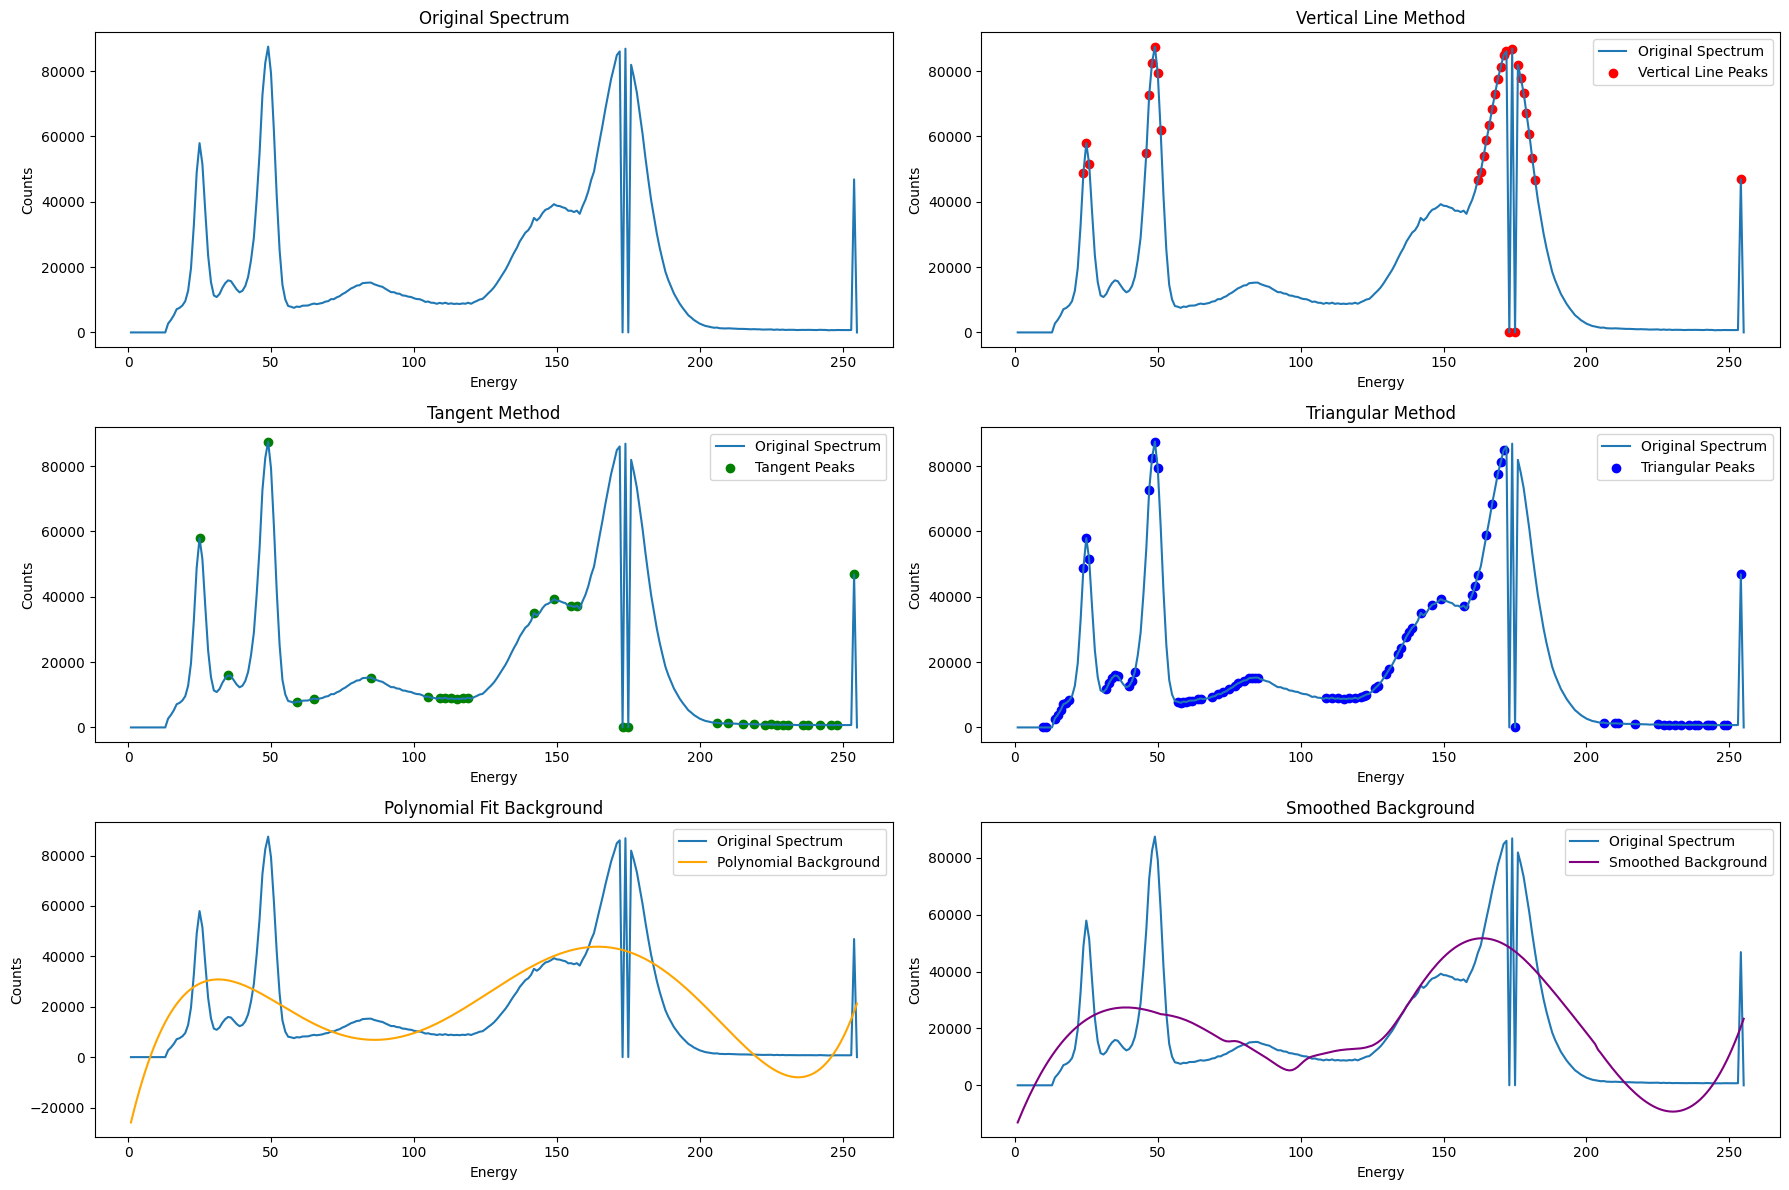

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# Load the data
filename = '15.5.csv'
data = pd.read_csv(filename)

# Assume the columns are named 'energy' and 'counts'
energy = data.iloc[:, 0].values
spectrum = data.iloc[:, 1].values

# 1. Geometric Methods
def vertical_line_method(spectrum, threshold=0.5):
    """
    Simple method to separate peaks based on vertical lines.
    """
    peak_indices = np.where(spectrum > threshold * np.max(spectrum))[0]
    return peak_indices

def tangent_method(spectrum):
    """
    Estimate peaks using the tangent method.
    """
    derivative = np.diff(spectrum)
    peaks = np.where((derivative[:-1] > 0) & (derivative[1:] < 0))[0] + 1
    return peaks

def triangular_method(spectrum):
    """
    Simple method to estimate peaks using triangular approximation.
    """
    smoothed = savgol_filter(spectrum, window_length=11, polyorder=2)
    peaks = np.where((spectrum > smoothed) & (np.concatenate(([False], spectrum[1:] > smoothed[:-1]))))[0]
    return peaks

# 2. Algebraic Methods
def polynomial_fit_background(energy, spectrum, degree=5):
    """
    Estimate background using polynomial fitting.
    """
    p = np.polyfit(energy, spectrum, degree)
    return np.polyval(p, energy)

def smooth_background(spectrum, window_length=101, polyorder=3):
    """
    Smooth the spectrum using Savitzky-Golay filter to estimate background.
    """
    return savgol_filter(spectrum, window_length=window_length, polyorder=polyorder)

# 3. Peak Deconvolution Methods
def simple_gaussian(x, amplitude, mean, stddev):
    """
    Gaussian function for fitting peaks.
    """
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def fit_peaks(energy, spectrum, n_peaks=2):
    """
    Fit Gaussian peaks to the spectrum.
    """
    # Initial guesses for the peak parameters
    initial_guess = []
    for i in range(n_peaks):
        initial_guess.extend([np.max(spectrum) / n_peaks, energy[np.argmax(spectrum)], 1.0])
        spectrum[np.argmax(spectrum)] = 0  # Avoid multiple peaks at the same location

    def gaussian_sum(x, *params):
        """Sum of multiple Gaussian functions."""
        return np.sum([simple_gaussian(x, params[i], params[i + 1], params[i + 2])
                       for i in range(0, len(params), 3)], axis=0)

    params, _ = curve_fit(gaussian_sum, energy, spectrum, p0=initial_guess)
    return gaussian_sum(energy, *params)

# Apply Methods
# Geometric Methods
vertical_peaks = vertical_line_method(spectrum)
tangent_peaks = tangent_method(spectrum)
triangular_peaks = triangular_method(spectrum)

# Algebraic Methods
background_poly = polynomial_fit_background(energy, spectrum)
background_smooth = smooth_background(spectrum)

# Peak Fitting
fitted_spectrum = fit_peaks(energy, spectrum)

# Plot the results
plt.figure(figsize=(18, 12))

# Original Spectrum
plt.subplot(3, 2, 1)
plt.plot(energy, spectrum, label='Original Spectrum')
plt.title('Original Spectrum')
plt.xlabel('Energy')
plt.ylabel('Counts')

# Geometric Methods
plt.subplot(3, 2, 2)
plt.plot(energy, spectrum, label='Original Spectrum')
plt.scatter(energy[vertical_peaks], spectrum[vertical_peaks], color='red', label='Vertical Line Peaks')
plt.title('Vertical Line Method')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(energy, spectrum, label='Original Spectrum')
plt.scatter(energy[tangent_peaks], spectrum[tangent_peaks], color='green', label='Tangent Peaks')
plt.title('Tangent Method')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(energy, spectrum, label='Original Spectrum')
plt.scatter(energy[triangular_peaks], spectrum[triangular_peaks], color='blue', label='Triangular Peaks')
plt.title('Triangular Method')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

# Algebraic Methods
plt.subplot(3, 2, 5)
plt.plot(energy, spectrum, label='Original Spectrum')
plt.plot(energy, background_poly, label='Polynomial Background', color='orange')
plt.title('Polynomial Fit Background')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(energy, spectrum, label='Original Spectrum')
plt.plot(energy, background_smooth, label='Smoothed Background', color='purple')
plt.title('Smoothed Background')
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.legend()

plt.tight_layout()
plt.show()
